## WARNING: This notebook requires fastai v1

In [1]:
from fastai.vision import *

In [2]:
%reload_ext autoreload
%autoreload 2

## Data

We are going to use the [Pascal dataset](http://host.robots.ox.ac.uk/pascal/VOC/) for object detection. There is a version from 2007 and a bigger version from 2012. We'll use the 2007 version here. 

In [3]:
torch.cuda.set_device(1)

In [4]:
DATA_PATH =  Path('../data/datasciencebowl')
TRAIN_PATH = DATA_PATH/'stage1_train'
TEST_PATH = DATA_PATH/'stage1_test'

In [5]:
train_ids = [f.name for f in TRAIN_PATH.glob('*')]
test_ids = [f.name for f in TEST_PATH.glob('*')]

In [6]:
def get_bbox_annotations(DATA_PATH):
    pts_raw_path = DATA_PATH/'box_annotations_3.pkl'

    if pts_raw_path.exists():
        box_annotations = pickle.load(open(pts_raw_path, 'rb'))
    else:
        box_annotations = []
        for tid in progress_bar(train_ids):
            path = TRAIN_PATH/tid
            img_path = Path(tid)/'images'/f'{tid}.png'

            bboxes = []
            labels = []
            for mask_file in (path/'masks').glob('*'):
                mask = imread(str(mask_file))
                bbox = bounding_boxes(mask)
                bboxes.append(bbox)

            box_annotations.append((img_path, bboxes))

        (pts_raw_path).save(box_annotations)
    return box_annotations




In [7]:
annotation_path = DATA_PATH/'bbox_train.json'
IMAGE_PATH = DATA_PATH/'bbox_train_all'
train_images, train_lbl_bbox = get_annotations(annotation_path)
# images = [IMAGE_PATH/i for i in images]

Here we will directly find the same image as before at the beginning of the training set, with the corresponding bounding box and category.

To see it, we open the image properly and we create an `ImageBBox` object from the list of bounding boxes. This will allow us to apply data augmentation to our bounding box. To create an `ImageBBox`, we need to give it the height and the width of the original picture, the list of bounding boxes, the list of category ids and the classes list (to map an id to a class).

Here we don't have a class dictionary available (that will be done automatically behind the scenes with the data block API), so we just pass id 0 and `classes=['car']`.

In [8]:
# IMAGE_PATH/train_images[0]

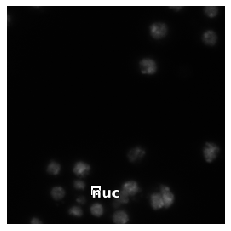

In [9]:
img = open_image(IMAGE_PATH/train_images[0])
bbox = ImageBBox.create(*img.size, [train_lbl_bbox[0][0][0]], [0], classes=['nuc'])
img.show(figsize=(6,4), y=bbox)

This works with one or several bounding boxes:

And if we apply a transform to our image and the `ImageBBox` object, they stay aligned:

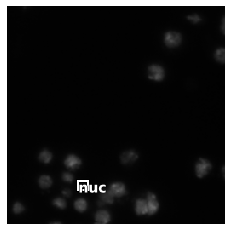

In [10]:
img = img.rotate(-10)
bbox = bbox.rotate(-10)
img.show(figsize=(6,4), y=bbox)

We group all the image filenames and annotations together, to use the data block API to load the dataset in a `DataBunch`.

In [11]:
images, lbl_bbox = train_images,train_lbl_bbox
img2bbox = dict(zip(images, lbl_bbox))
# get_y_func = lambda o:img2bbox[o.name]

In [12]:
def get_y_func(x):
    lbl = img2bbox[x.name]
#     lbl[1] = ['' for l in lbl[1]]
    return lbl

In [13]:
IMAGE_PATH

PosixPath('../data/datasciencebowl/bbox_train_all')

In [14]:
VAL_IMAGE_IDS = set(['8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1',
 '1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9',
 '6d327ab4f0e3604fa6e9b8041c7e6db86ab809890d886c691f6e59c9168b7fbe',
 'a4c729efb5059893a8b62c7abeba171cb516836f8a20468f6b176dfe2f6f84d1',
 '5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3',
 'cbff60361ded0570e5d50429a1aa51d81471819bc9b38359f03cfef76de0038c',
 '6bc8cda54f5b66a2a27d962ac219f8075bf7cc43b87ba0c9e776404370429e80',
 '62570c4ff1c5ab6d9d383aba9f25e604768520b4266afd40fdf4734a694c8bc3',
 '0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93',
 '13f2bec0a24c70345372febb14c4352877b1b6c1b01896246048e83c345c0914',
 'b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39ff843884d84f61dee1',
 'bf566e75d5cb0196de4139573f8bbbda0fa38d5048edf7267fe8793dcc094a66',
 'e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2',
 'ddf1bf458312de2895dd9cc5ce7ec9d334ad54c35edc96ad6001d20b1d8588d8',
 'a7f6194ddbeaefb1da571226a97785d09ccafc5893ce3c77078d2040bccfcb77',
 'dbbfe08a52688d0ac8de9161cbb17cb201e3991aacab8ab8a77fe0e203a69481',
 '3b0709483b1e86449cc355bb797e841117ba178c6ae1ed955384f4da6486aa20',
 'aa4d989d262c618ac2793579e200cc71b3767f84698ae5f669867f23cdfe2568',
 'c0f172831b8017c769ff0e80f85b096ac939e79de3d524e0826fbb95221365da',
 'ebc18868864ad075548cc1784f4f9a237bb98335f9645ee727dac8332a3e3716',
 '66236902b874b7e4b3891db63a69f6d56f6edcec6aca7ba3c6871d73e7b4c34f',
 'e9b8ad127f2163438b6236c74938f43d7b4863aaf39a16367f4af59bfd96597b',
 'df9a4212ecb67bb4e58eba62f293b91f9d6f1dde73e38fa891c75661d419fc97',
 '2b50b1e3fa5c5aa39bc84ebfaea9961b7199c4d2488ae0b48d0b3459807d59d2',
 'b6d50fa22380ae3a7e8c52c5bc44a254e7b2596fd8927980dbe2c160cb5689b5',
 '6fb82031f7fc5f4fa6e0bc2ef3421db19036b5c2cdd2725009ab465d66d61d72',
 'd4d88391bc399a3715440d4da9f8b7a973e010dc1edd9551df2e5a538685add5',
 'eb1df8ed879d04b36980b0958a0e8fc446ad08c0bdcf3b5f42e3db023187c7e5',
 'dad607a203483439fcbc2acecd0a39fb5e5a94a32a94348f5c802c79cfeb6e7c',
 'a022908f1b7880838dbc0411e50828e64b4f5e0263afdf04295e30bb2ff58005',
 '9c95eae11da041189e84cda20bdfb75716a6594684de4b6ce12a9aaadbb874c9',
 'b3bfd873fca7ff9b2e90f507dfdbe165bb8c153399b6ba5829aa59bae677a91d',
 'dec1764c00e8b3c4bf1fc7a2fda341279218ff894186b0c2664128348683c757',
 'b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38',
 '57bd029b19c1b382bef9db3ac14f13ea85e36a6053b92e46caedee95c05847ab',
 '1db1cddf28e305c9478519cfac144eee2242183fe59061f1f15487e925e8f5b5',
 '6bd18a218d25247dc456aed124c066a6397fb93086e860e4d04014bfa9c9555d',
 'd7d12a2acc47a94961aeb56fd56e8a0873016af75f5dd10915de9db8af8e4f5e',
 'da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c137f101d920',
 '7798ca1ddb3133563e290c36228bc8f8f3c9f224e096f442ef0653856662d121',
 '8d29c5a03e0560c8f9338e8eb7bccf47930149c8173f9ba4b9279fb87d86cf6d',
 '33a5b0ff232b425796ee6a9dd5b516ff9aad54ca723b4ec490bf5cd9b2e2a731',
 'c3bec1066aae20f48b82975e7e8b684cd67635a8baf211e4d9e3e13bc54c5d06',
 '4829177d0b36abdd92c4ef0c7834cbc49f95232076bdd7e828f1f7cbb5ed80ec',
 'f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24',
 '4185b9369fc8bdcc7e7c68f2129b9a7442237cd0f836a4b6d13ef64bf0ef572a',
 '1815cf307859b3e13669041d181aa3b3dbbac1a95aef4c42164b223110c09168',
 'fc9269fb2e651cd4a32b65ae164f79b0a2ea823e0a83508c85d7985a6bed43cf',
 'a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288',
 '8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4',
 '6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc',
 '0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0',
 '3d0ca3498d97edebd28dbc7035eced40baa4af199af09cbb7251792accaa69fe',
 '8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832',
 '1a75e9f15481d11084fe66bc2a5afac6dc5bec20ed56a7351a6d65ef0fe8762b',
 'a3a1b8f9794ef589b71faa9f35fd97ad6761c4488718fbcf766e95e31afa8606',
 '5488e8df5440ee5161fdfae3aeccd2ee396636430065c90e3f1f73870a975991',
 '8cdbdda8b3a64c97409c0160bcfb06eb8e876cedc3691aa63ca16dbafae6f948',
 'c2a646a819f59a4e816e0ee8ea00ba10d5de9ac20b5a435c41192637790dabee',
 '136000dc18fa6def2d6c98d4d0b2084d13c22eaffe82e26c665bcaa2a9e51261',
 'a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7',
 '831218e6a1a54b23d4be56c5799854e7eb978811b89215319dc138900bd563e6',
 '2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a',
 '2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707',
 '1e61ecf354cb93a62a9561db87a53985fb54e001444f98112ed0fc623fad793e',
 '2ad489c11ed8b77a9d8a2339ac64ffc38e79281c03a2507db4688fd3186c0fe5',
 'be771d6831e3f8f1af4696bc08a582f163735db5baf9906e4729acc6a05e1187'])
valid_idxs = [idx for idx,image in enumerate(images) if Path(image).stem in set(VAL_IMAGE_IDS)]

In [15]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(IMAGE_PATH)
#     src = src.split_by_files(val_images)
    src = src.split_by_valid_func(lambda x: x.stem in VAL_IMAGE_IDS)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    data = src.databunch(path=IMAGE_PATH, bs=bs, collate_fn=bb_pad_collate)
    data.c = 1
    return data

In [16]:
data = get_data(64,128)

In [17]:
len(data.train_ds), len(data.valid_ds)

(603, 67)

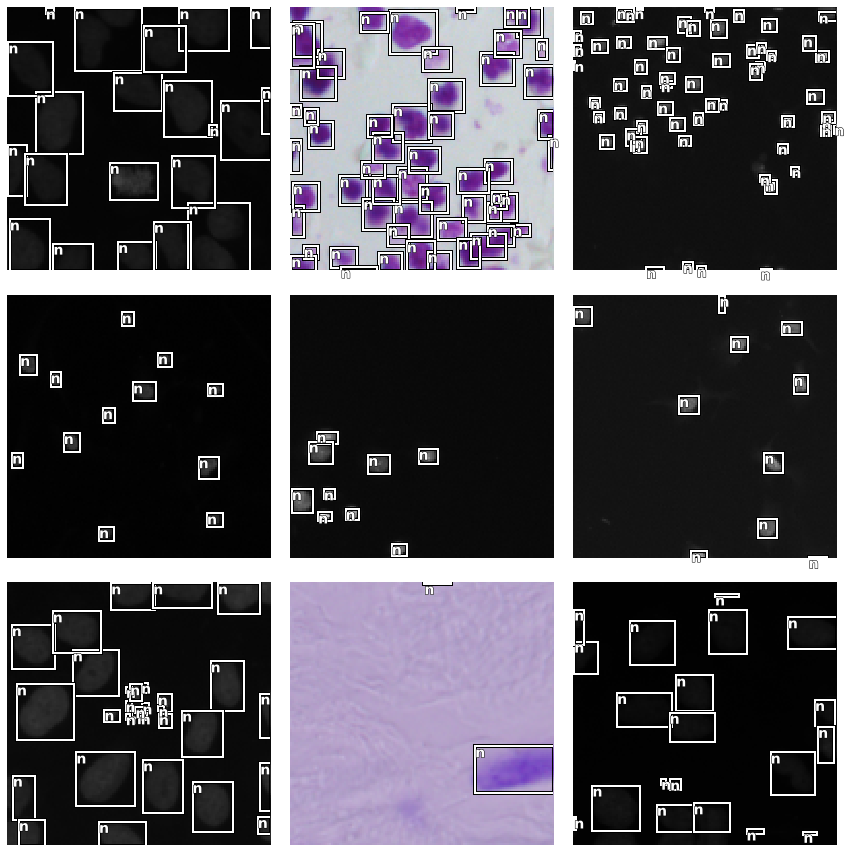

In [18]:
data.show_batch(rows=3)

## Model

In [19]:
from fastai.vision import conv2d

In [21]:
from fastaiv2_retinanet import *

## Defining the Learner

In [22]:
# ratios = [1/2,1,2]
# scales = [1,2**(-1/3), 2**(-2/3)]

ratios = [1]
scales = [1, 0.5, 0.25]
#scales = [1,2**(1/3), 2**(2/3)] for bigger size

In [23]:
def unpad(bbox_tgt, clas_tgt, pad_idx=0):
    idxs = torch.nonzero(clas_tgt-pad_idx)
    if len(idxs) == 0: 
        i = len(bbox_tgt) - 1
#             print('Background', bbox_tgt, clas_tgt)
#             return idxs, clas_tgt[i:]-1+self.pad_idx
    else: i = torch.min(idxs)
    return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+pad_idx

def _unpad(self, bbox_tgt, clas_tgt): return unpad(bbox_tgt, clas_tgt, self.pad_idx)
RetinaNetFocalLoss._unpad = _unpad

In [24]:
encoder = create_body(models.resnet50, cut=-2)
model = RetinaNet(encoder, data.c, final_bias=-4, n_anchors=len(ratios)*len(scales))
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

Why `final_bias=-4`? That's because we want the network to predict background easily at the beginning (since it's the most common class). At first the final convolution of the classifier is initialized with weights=0 and that bias, so it will return -4 for everyone. If go though a sigmoid 

We see it'll give a corresponding probability of 0.02 roughly. 

Then, for transfer learning/discriminative LRs, we need to define how to split between body and custom head.

In [25]:
def retina_net_split(model):
    groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
    return groups + [list(model.children())[1:]]

In [26]:
learn = learn.split(retina_net_split)

And now we can train as usual!

In [ ]:
learn.data = get_data(64,128)
learn.unfreeze()

In [29]:
learn.fit_one_cycle(20, 1e-4)

epoch,train_loss,valid_loss,time
0,3.442663,3.460487,00:09
1,3.301111,2.851297,00:07
2,2.970463,2.244432,00:07
3,2.645730,2.009644,00:07
4,2.393151,1.745534,00:07
5,2.190353,1.556884,00:07
6,2.026825,1.459415,00:07
7,1.889184,1.385715,00:07
8,1.765832,1.243165,00:07
9,1.650862,1.192660,00:07


In [30]:
learn.save('miccai_small')

## Train

In [31]:
learn.data = get_data(24,192)
learn.unfreeze()
learn.fit_one_cycle(60, 1e-4)

epoch,train_loss,valid_loss,time
0,0.983179,0.896319,00:12
1,0.919173,0.893162,00:10
2,0.886781,0.833243,00:10
3,0.866978,0.847349,00:10
4,0.845548,0.776523,00:10
5,0.819278,0.795387,00:10
6,0.787227,0.753700,00:10
7,0.757753,0.686371,00:09
8,0.729720,0.684493,00:10
9,0.705064,0.660605,00:10


In [32]:
learn.save('miccai-try2')

In [31]:
learn = learn.load('miccai-try2')

In [32]:
learn.data = get_data(24,256)

In [33]:
learn.unfreeze()
learn.fit_one_cycle(60, 1e-4)

epoch,train_loss,valid_loss,time
0,0.335718,0.332273,00:13
1,0.329685,0.334755,00:13
2,0.326761,0.313916,00:13
3,0.323810,0.323176,00:13
4,0.320243,0.327244,00:13
5,0.317124,0.326344,00:13
6,0.319663,0.338376,00:13
7,0.320272,0.328667,00:13
8,0.320679,0.333964,00:13
9,0.321274,0.326714,00:13


In [28]:
learn.save('miccai-try3')

## Results

In [29]:
bs = 16
learn.data = get_data(bs,256)
learn = learn.load('miccai-try3')

In [30]:
xb,yb = learn.data.one_batch(DatasetType.Valid, cpu=False)

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(learn.model)

36064079

Helper functions to plot the results

In [32]:
def _draw_outline(o:Patch, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

In [33]:
def show_preds(img, output, idx, scales, ratios, detect_thresh=0.25, nms_thresh=0.35, classes=None, ax=None):
    bbox_pred, scores, preds = process_output(output, idx, scales, ratios, detect_thresh)
    if len(scores) != 0:
        to_keep = nms(bbox_pred, scores, nms_thresh)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
        bbox_pred = bbox_pred.long()
    if ax is None: _, ax = plt.subplots(1,1)
    img.show(ax=ax)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

And let's have a look at one picture.

In [34]:
idx = 0

In [35]:
img,target = next(iter(data.valid_dl))
with torch.no_grad():
    output = learn.model(img)

In [36]:
outputs = []
with torch.no_grad():
    for input,target in progress_bar(learn.data.valid_dl):
        output = learn.model(input)
        outputs.append((input,target,output))

In [37]:
idx = 53

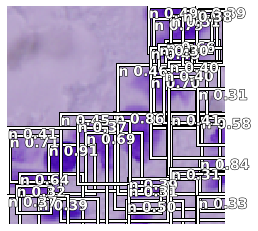

In [38]:
img = data.valid_ds[idx][0]
show_preds(img, outputs[idx//bs][2], idx%16, scales, ratios, detect_thresh=0.3, nms_thresh=0.3, classes=data.classes)
idx += 1

It looks like a lot of our anchors are detecting kind of the same object. We use an algorithm called Non-Maximum Suppression to remove near-duplicates: going from the biggest score predicted to the lowest, we take the corresponding bounding boxes and remove all the bounding boxes down the list that have an IoU > 0.5 with this one. We continue the process until we have reached the end of the list.

## mAP

A metric often used for this kind of task is the mean Average Precision (our mAP). It relies on computing the cumulated precision and recall for each class, then tries to compute the area under the precision/recall curve we can draw.

In [41]:
def get_predictions(output, idx, scales, ratios, detect_thresh=0.35, nms_thresh=0.3):
    bbox_pred, scores, preds = process_output(output, idx, scales, ratios, detect_thresh)
    if len(scores) == 0: return [],[],[]
    to_keep = nms(bbox_pred, scores, nms_thresh)
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]

In [42]:
def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
#     print(recall.shape, precision.shape, recall.mean(), precision.mean())
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

In [43]:
def bbox2center(bb):
    return torch.stack((bb[:,0]+bb[:,2]/2,bb[:,1]+bb[:,3]/2), -1)

def euc_dist(a, b):
    # https://stackoverflow.com/questions/27948363/numpy-broadcast-to-perform-euclidean-distance-vectorized
    return np.sqrt((np.square(a[:,np.newaxis]-b).sum(axis=2)))

In [53]:
def compute_class_APR(outputs, n_classes, iou_thresh=0.5, detect_thresh=0.35, nms_thresh=0.5, max_dist=5):
    tps, clas, p_scores = [], [], []
    classes, n_gts = LongTensor(range(n_classes)),torch.zeros(n_classes).long()
    for input,target,output in outputs:
        for i in range(target[0].size(0)):
            bbox_pred, preds, scores = get_predictions(output, i, scales, ratios, detect_thresh, nms_thresh)
            tgt_bbox, tgt_clas = unpad(target[0][i], target[1][i])
            if len(bbox_pred) != 0 and len(tgt_bbox) != 0:
                pc = bbox2center(bbox_pred)
                tc = bbox2center(tgt_bbox)
#                 pdb.set_trace()
                pc = (pc+1)/2 * 256
                tc = (tc+1)/2 * 256
                dist = euc_dist(pc, tc)
                min_dist, matches = dist.min(1)
                detected = []
                for i in range_of(preds):
                    if min_dist[i] <= max_dist and matches[i] not in detected and tgt_clas[matches[i]] == preds[i]:
                        detected.append(matches[i])
                        tps.append(1)
                    else: tps.append(0)
                clas.append(preds.cpu())
                p_scores.append(scores.cpu())
            n_gts += (tgt_clas.cpu()[:,None] == classes[None,:]).sum(0)
    tps, p_scores, clas = torch.tensor(tps), torch.cat(p_scores,0), torch.cat(clas,0)
    fps = 1-tps
    idx = p_scores.argsort(descending=True)
    tps, fps, clas = tps[idx], fps[idx], clas[idx]
    aps = []
    for cls in range(n_classes):
        tps_cls, fps_cls = tps[clas==cls].float().cumsum(0), fps[clas==cls].float().cumsum(0)
        if tps_cls.numel() != 0 and tps_cls[-1] != 0:
            precision = tps_cls / (tps_cls + fps_cls + 1e-8)
            recall = tps_cls / (n_gts[cls] + 1e-8)
        
            p=precision[-1]
            r=recall[-1]
            F1 = (2 * (p * r) / (p + r))
            aps.append(compute_ap(precision, recall))
            aps.append(F1)
        else: aps.append(0.)
    return aps

In [54]:
for d in [2,5,10]:
    aps = []
    for i in [0.2, 0.3, 0.4]:
        for j in [0.2, 0.3, 0.4]:
            aps.append((compute_class_APR(outputs, data.c, detect_thresh=i, nms_thresh=j, max_dist=d), d, i, j, ))
    print(max(aps))

([0.10923882871276056, tensor(0.1412)], 2, 0.2, 0.4)
([0.6045083980323684, tensor(0.4093)], 5, 0.2, 0.3)
([0.8204570232459618, tensor(0.6480)], 10, 0.2, 0.2)
